In [1]:
!pip3 install torch torchvision

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import imageio as io
import pandas as pd

import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.io import read_image

from torch.utils.data import DataLoader
from torchvision import transforms

Epoch: 0, Average loss: 3.405539, Validation loss: 3.314415, Train accuracy: 0.238750, Val accuracy: 0.276000
Epoch: 1, Average loss: 3.381701, Validation loss: 3.348620, Train accuracy: 0.265000, Val accuracy: 0.252000
Epoch: 2, Average loss: 3.353253, Validation loss: 3.323738, Train accuracy: 0.288250, Val accuracy: 0.263000
Epoch: 3, Average loss: 3.326610, Validation loss: 3.284973, Train accuracy: 0.310750, Val accuracy: 0.328000
Epoch: 4, Average loss: 3.303165, Validation loss: 3.212832, Train accuracy: 0.333000, Val accuracy: 0.421000
Epoch: 5, Average loss: 3.277719, Validation loss: 3.229081, Train accuracy: 0.378500, Val accuracy: 0.396000
Epoch: 6, Average loss: 3.244914, Validation loss: 3.210347, Train accuracy: 0.430000, Val accuracy: 0.415000
Epoch: 7, Average loss: 3.206378, Validation loss: 3.172017, Train accuracy: 0.447000, Val accuracy: 0.445000
Epoch: 8, Average loss: 3.166339, Validation loss: 3.130500, Train accuracy: 0.452750, Val accuracy: 0.459000
Epoch: 9, 

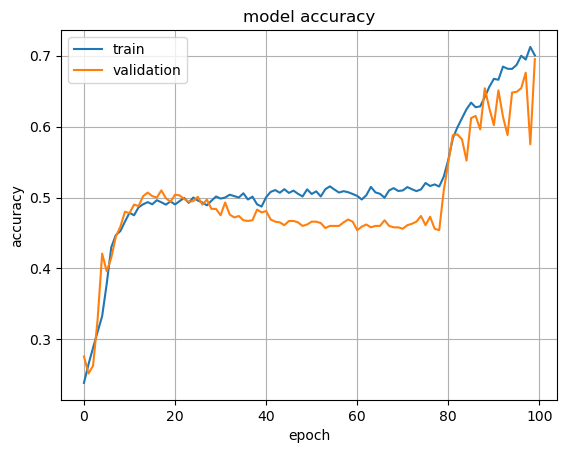

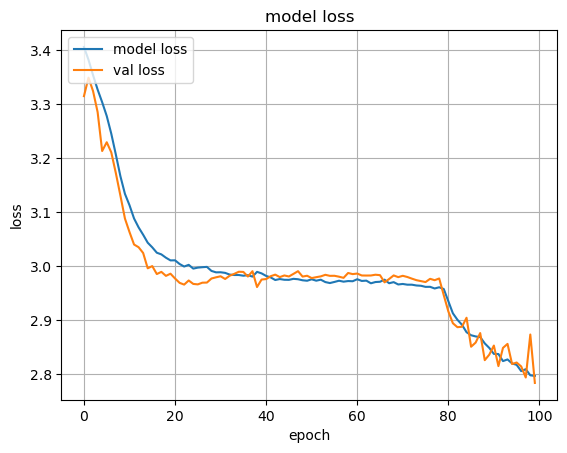

In [3]:
device = torch.device("cuda")



class gaussian(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()

    def forward(self, inp):
        return torch.exp(-((inp - torch.mean(inp)) ** 2) / (torch.std(inp)) ** 2)

class SRMConv(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.srm = torch.from_numpy(np.load("/kaggle/input/srm-for-stego/srm.npy")).to(device).type(torch.cuda.FloatTensor)
        self.tlu = nn.Hardtanh(min_val=-3.0, max_val=3.0)

    def forward(self, inp):
        return self.tlu(F.conv2d(inp, self.srm, stride=(1,1), bias=torch.from_numpy(np.ones(30)).type(torch.cuda.FloatTensor)))

class DepthwiseConv2d(nn.Module):
    def __init__(self, in_f, depth, kernel_size=3, pading=1) -> None:
        super(DepthwiseConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_f, in_f * depth, kernel_size=kernel_size, padding=pading, groups=in_f)
    def forward(self, x):
        out = self.depthwise(x)
        return out

class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, bias=False, depth_multiplier=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels * depth_multiplier, kernel_size=kernel_size, 
                                   groups=in_channels, bias=bias, padding=1)
        self.pointwise = nn.Conv2d(in_channels * depth_multiplier, out_channels, 
                                   kernel_size=1, bias=bias)
        self.elu = nn.ELU()

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        out = self.elu(out)
        return out
    
class ConvBn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False, stride=(1,1)):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=stride)
        self.elu = nn.ELU()

    def forward(self, x):
        out = self.conv(x)
        out = self.elu(out)
        return out
class SRMKovNet(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.batchN1 = nn.BatchNorm2d(30,eps=0.001, momentum=0.2)
        #         self.srm = SRMConv()
        self.first_block = nn.Sequential(
           DepthwiseConv2d(30,1),
            SeparableConv2d(30,30,(3,3),depth_multiplier=3),
            nn.BatchNorm2d(30,eps=0.001, momentum=0.2),
            DepthwiseConv2d(30,1),
            SeparableConv2d(30,30,(3,3),depth_multiplier=3),
            nn.BatchNorm2d(30,eps=0.001, momentum=0.2)
        )
        
        self.second_block = nn.Sequential(
            ConvBn(30,30,(3,3),stride=(1,1)),
             nn.BatchNorm2d(30,eps=0.001, momentum=0.2),
            ConvBn(30,30,(3,3),stride=(1,1)),
             nn.BatchNorm2d(30,eps=0.001, momentum=0.2),
            nn.AvgPool2d(kernel_size=(2,2), stride = (2,2)),
            ConvBn(30,60,(3,3),stride=(1,1)),
            nn.BatchNorm2d(60,eps=0.001, momentum=0.2)
        )
        self.third_block = nn.Sequential(
           DepthwiseConv2d(60,1),
            SeparableConv2d(60,60,(3,3),depth_multiplier=3),
            nn.BatchNorm2d(60,eps=0.001, momentum=0.2),
           DepthwiseConv2d(60,1),
            SeparableConv2d(60,60,(3,3),depth_multiplier=3),
            nn.BatchNorm2d(60,eps=0.001, momentum=0.2),
        )
        self.fourth_block = nn.Sequential(
            ConvBn(60,60,(3,3),stride=(1,1)),
             nn.BatchNorm2d(60,eps=0.001, momentum=0.2),
            nn.AvgPool2d(kernel_size=(2,2), stride = (2,2)),
            ConvBn(60,60,(3,3),stride=(1,1)),
            nn.BatchNorm2d(60,eps=0.001, momentum=0.2),
            nn.AvgPool2d(kernel_size=(2,2), stride = (2,2)),
            ConvBn(60,60,(3,3),stride=(1,1)),
             nn.BatchNorm2d(60,eps=0.001, momentum=0.2),
            nn.AvgPool2d(kernel_size=(2,2), stride = (2,2)),
            ConvBn(60,60,(1,1),stride=(1,1)),
            nn.BatchNorm2d(60,eps=0.001, momentum=0.2),
            ConvBn(60,30,(1,1),stride=(1,1)),
             nn.BatchNorm2d(30,eps=0.001, momentum=0.2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inp):
        out = SRMConv()(inp)
        out = self.batchN1(out)
        out = self.first_block(out) + out
        out = self.second_block(out)
        out = self.third_block(out) + out
        out = self.fourth_block(out)
        out = out.view(out.size(0), -1)
        out = self.softmax(out)
        return out

class CustomDataset:
    def __init__(self, img_dir,amount, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.amount = amount

    def __len__(self):
        return self.amount

    def __getitem__(self, idx):
        image = None
        num = int(idx / 2) + 1
        label = idx % 2
        if label == 0:
            image = PIL.Image.open(self.img_dir + "cover/" +  str(num) + ".pgm")
        else:
            image = PIL.Image.open(self.img_dir + "stego/" +  str(num) + ".pgm")
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        idx += 1
        return (image, label)

data_train = CustomDataset('/kaggle/input/hugo-boss-base/HUGO_dataset/', 14000, transform=transforms.Compose([
                           transforms.ToTensor()
]))
data_test = CustomDataset('/kaggle/input/hugo-boss-base/HUGO_dataset/',6000, transform=transforms.Compose([
                           transforms.ToTensor()
]))

batch_size = 32

data_size = 5000

validation_split = .2

num_epochs = 100

split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))

np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)



train_loader = DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

nn_model = SRMKovNet()

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

criterion = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

optimizer = torch.optim.Adam(
        nn_model.parameters(),
        lr=0.001,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0,
    )

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            x_gpu = inputs.to(device)
            y_gpu = labels.to(device)
            optimizer.zero_grad()
            outputs = model(x_gpu)
            loss = criterion(outputs, y_gpu)

            loss.backward()
            optimizer.step()

            _, indices = torch.max(outputs, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += labels.shape[0]
            
            loss_accum += loss

        ave_loss = loss_accum / i
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy, val_loss = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        val_losses.append(val_loss)
        
        print("Epoch: %d, Average loss: %f, Validation loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, val_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history, val_losses

def compute_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            predictions = model(x_gpu)
            loss = criterion(predictions, y_gpu)
            losses.append(loss.item())
            _, predicted = torch.max(predictions.data, 1)
            total += y_gpu.size(0)
            correct += (predicted == y_gpu).sum().item()
    return correct/total, sum(losses)/len(losses)

def Plt_hist(loss_history, train_history, val_history, val_losses):
     plt.plot(train_history)
     plt.plot(val_history)
     plt.title('model accuracy')
     plt.xlabel('epoch')
     plt.ylabel('accuracy')
     plt.legend(['train','validation'], loc='upper left')
     plt.grid()
     plt.show()
     plt.plot(loss_history)
     plt.plot(val_losses)
     plt.title('model loss')
     plt.xlabel('epoch')
     plt.ylabel('loss')
     plt.legend(['model loss', 'val loss'], loc='upper left')
     plt.grid()
     plt.show()

loss_history, train_history, val_history, val_losses = train_model(nn_model, train_loader, val_loader, criterion, optimizer, num_epochs)

Plt_hist(loss_history, train_history, val_history, val_losses)

In [4]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

def evaluate_model(model, loader, indices):
    model.eval() 

    predictions=[]
    ground_truth=[]
    for index in indices:
        x, y = loader[index]
        x_gpu=x.to(device)
        y_gpu=y.to(device)
        prediction = model(x_gpu)
        _, prediction = torch.max(outputs, 1)
        predictions.append(prediction)
        ground_truth.append(y)
    return predictions, ground_truth

predictions, gt = evaluate_model(nn_model, data_test, list(range(7001,10001)))


def build_confusion_matrix(predictions, ground_truth):
    confusion_matrix = np.zeros((2,2), np.int_)
    for i in range (len(predictions)):
        confusion_matrix[predictions[i]][ground_truth[i]] += 1
    return confusion_matrix

def visualize_confusion_matrix(confusion_matrix):
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(2,2))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
            
            
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

TypeError: not all arguments converted during string formatting